In [83]:
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
%matplotlib inline
import pandas as pd
import glob
import seaborn as sns
import gemmi
import scipy.spatial.distance as spsd

In [170]:
input_MTZ = rs.read_mtz('./F_internal_200us_540uJ_diffmap_W0-05.mtz')
# input_MTZ["sf"] = input_MTZ.to_structurefactor("WDF", "PHIFMODEL")
# reciprocalgrid = input_MTZ.to_reciprocalgrid("sf", gridsize=(128, 128, 128))
# input_MTZ.cell.a/(input_MTZ.attrs)
input_MTZ.compute_dHKL(inplace=True)
grid_sampling = 0.25
print(int(input_MTZ.cell.a/(input_MTZ.dHKL.min()*grid_sampling)))

202


In [171]:
def find_sites(realmap, threshold, cell):
    """
    Find local peaks in map.

    Parameters
    ----------
    realmap : np.ndarray
        3D array with voxelized electron density
    threshold : float
        Minimum voxelized density to consider for peaks
    cell : gemmi.UnitCell
        Cell parameters for crystal

    Returns
    -------
    pd.DataFrame
        DataFrame with coordinates and peak height for each site
    """
    from skimage import feature
    peaks = feature.peak_local_max(realmap, threshold_abs=threshold, exclude_border=False)
    data = []
    for p in peaks:
        pf = p/np.array(realmap.shape)
        pf_2 = pf + np.array([-1, 0, 0])
        pf_3 = pf + np.array([0, 0, 1])
        pf_4 = pf + np.array([-1, 0, -1])
        pos = cell.orthogonalize(gemmi.Fractional(*pf))
        pos_2 = cell.orthogonalize(gemmi.Fractional(*pf_2))
        pos_3 = cell.orthogonalize(gemmi.Fractional(*pf_3))
        pos_4 = cell.orthogonalize(gemmi.Fractional(*pf_4))
        d  = {"x": pos.x, "y": pos.y, "z": pos.z}
        d_2  = {"x": pos_2.x, "y": pos_2.y, "z": pos_2.z}
        d_3  = {"x": pos_3.x, "y": pos_3.y, "z": pos_3.z}
        d_4  = {"x": pos_4.x, "y": pos_4.y, "z": pos_4.z}
        d["height"] = realmap[p[0], p[1], p[2]]
        d_2["height"] = realmap[p[0], p[1], p[2]]
        d_3["height"] = realmap[p[0], p[1], p[2]]
        d_4["height"] = realmap[p[0], p[1], p[2]]
        data.append(d)
        data.append(d_2)
        data.append(d_3)
        data.append(d_4)
    return pd.DataFrame(data)


def write_pdb(sites, cell):
    s = gemmi.Structure()
    s.cell = cell
    m = gemmi.Model("substructure")
    c = gemmi.Chain("A")
    for i, site in sites.iterrows():
        a = gemmi.Atom()
        a.element = gemmi.Element("S")
        a.name = "S"
        a.pos = gemmi.Position(*site[["x", "y", "z"]].values)
        r = gemmi.Residue()
        r.name = "S"
        r.seqid = gemmi.SeqId(str(i+1))
        r.add_atom(a)
        c.append_residues([r])
    m.add_chain(c)
    s.add_model(m)
    s.assign_label_seq_id(force=True)
    s.write_minimal_pdb("sites_quad_pos.pdb")
    return

def IADDAT(input_PDB_filename, input_MTZ_filename, threshold_dict, distance_cutoff, average_out=False):
    name_init = input_MTZ_filename.replace("./F_internal_","")
    name = name_init.replace("_diffmap_W0-05.mtz","")
    elements = [gemmi.Element('C'), gemmi.Element('N'), gemmi.Element('O'), gemmi.Element('S')]
    
    input_PDB = gemmi.read_structure(input_PDB_filename)
    input_MTZ = rs.read_mtz(input_MTZ_filename)
    input_MTZ.compute_dHKL(inplace=True)
    grid_sampling = 0.25
    a_sampling = int(input_MTZ.cell.a/(input_MTZ.dHKL.min()*grid_sampling))
    b_sampling = int(input_MTZ.cell.b/(input_MTZ.dHKL.min()*grid_sampling))
    c_sampling = int(input_MTZ.cell.c/(input_MTZ.dHKL.min()*grid_sampling))
    input_MTZ["sf"] = input_MTZ.to_structurefactor("WDF", "PHIFMODEL")
    reciprocalgrid = input_MTZ.to_reciprocalgrid("sf", gridsize=(a_sampling, b_sampling, c_sampling))
    realmap = np.real(np.fft.fftn(reciprocalgrid))
    sites = find_sites(realmap, realmap.std()*threshold_dict[name], input_MTZ.cell)
    sites_neg = find_sites(realmap*-1, realmap.std()*threshold_dict[name], input_MTZ.cell)
    sites_coords = np.array([sites.x, sites.y, sites.z])
    sites_neg_coords = np.array([sites_neg.x, sites_neg.y, sites_neg.z])
    
    IADDAT = []
    for residue in input_PDB[0]["A"]:
        atom_coords = []
        for atom in residue:
            if atom.element in elements:
                pos  = {"x": atom.pos.x, "y": atom.pos.y, "z": atom.pos.z}
                atom_coords.append(pos)
            else:
                pass
        atom_coords_df = pd.DataFrame(atom_coords)
        
        if atom_coords_df.empty:
            print("non AA processed")
            pass
        else:
            distances_pos = spsd.cdist(atom_coords_df, sites_coords.transpose())
            filter_pos = []
            for row in distances_pos.transpose():
                filt_pos = np.any(row <= distance_cutoff)
                filter_pos.append(filt_pos)
            filt_pos_df = pd.DataFrame(filter_pos)

            sites["filtered"] = filt_pos_df
            integrate_pos = sites.loc[sites['filtered'] == True]
            int_pos_value = integrate_pos.height.sum()

            distances_neg = spsd.cdist(atom_coords_df, sites_neg_coords.transpose())
            filter_neg = []
            for row in distances_neg.transpose():
                filt_neg = np.any(row <= distance_cutoff)
                filter_neg.append(filt_neg)
            filt_neg_df = pd.DataFrame(filter_neg)

            sites_neg["filtered"] = filt_neg_df
            integrate_neg = sites_neg.loc[sites_neg['filtered'] == True]
            int_neg_value = integrate_neg.height.sum()

            int_value = int_pos_value + int_neg_value
            if average_out:
                new_int_value = int_value / len(atom_coords)
                IADDAT.append(new_int_value)
            else:
                IADDAT.append(int_value)
    
    return IADDAT

# def IADDAT_depreciated(input_PDB_filename, input_MTZ_filename, threshold_dict, distance_cutoff, average_out=False):
#     name_init = input_MTZ_filename.replace("./F_internal_","")
#     name = name_init.replace("_diffmap_W0-05.mtz","")
#     elements = [gemmi.Element('C'), gemmi.Element('N'), gemmi.Element('O'), gemmi.Element('S')]
    
#     input_PDB = gemmi.read_structure(input_PDB_filename)
#     input_MTZ = rs.read_mtz(input_MTZ_filename)
#     input_MTZ["sf"] = input_MTZ.to_structurefactor("WDF", "PHIFMODEL")
#     reciprocalgrid = input_MTZ.to_reciprocalgrid("sf", gridsize=(128, 128, 128))
#     realmap = np.real(np.fft.fftn(reciprocalgrid))
#     sites = find_sites(realmap, realmap.std()*threshold_dict[name], input_MTZ.cell)
#     sites_neg = find_sites(realmap*-1, realmap.std()*threshold_dict[name], input_MTZ.cell)
#     sites_coords = np.array([sites.x, sites.y, sites.z])
#     sites_neg_coords = np.array([sites_neg.x, sites_neg.y, sites_neg.z])
    
#     IADDAT = []
#     for residue in input_PDB[0]["A"]:
#         atom_coords = []
#         for atom in residue:
#             if atom.element in elements:
#                 pos  = {"x": atom.pos.x, "y": atom.pos.y, "z": atom.pos.z}
#                 atom_coords.append(pos)
#             else:
#                 pass
#         atom_coords_df = pd.DataFrame(atom_coords)
        
#         if atom_coords_df.empty:
#             print("non AA processed")
#             pass
#         else:
#             distances_pos = spsd.cdist(atom_coords_df, sites_coords.transpose())
#             filter_pos = []
#             for row in distances_pos.transpose():
#                 filt_pos = np.any(row <= distance_cutoff)
#                 filter_pos.append(filt_pos)
#             filt_pos_df = pd.DataFrame(filter_pos)

#             sites["filtered"] = filt_pos_df
#             integrate_pos = sites.loc[sites['filtered'] == True]
#             int_pos_value = integrate_pos.height.sum()

#             distances_neg = spsd.cdist(atom_coords_df, sites_neg_coords.transpose())
#             filter_neg = []
#             for row in distances_neg.transpose():
#                 filt_neg = np.any(row <= distance_cutoff)
#                 filter_neg.append(filt_neg)
#             filt_neg_df = pd.DataFrame(filter_neg)

#             sites_neg["filtered"] = filt_neg_df
#             integrate_neg = sites_neg.loc[sites_neg['filtered'] == True]
#             int_neg_value = integrate_neg.height.sum()

#             int_value = int_pos_value + int_neg_value
#             if average_out:
#                 new_int_value = int_value / len(atom_coords)
#                 IADDAT.append(new_int_value)
#             else:
#                 IADDAT.append(int_value)
    
#     return IADDAT



In [87]:
# test = rs.read_mtz("./F_internal_20ns_540uJ_diffmap_W0-05.mtz")
# tesPDB = gemmi.read_structure("./F_internal_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb")

In [88]:
# test["sf"] = test.to_structurefactor("WDF", "PHIFMODEL")
# reciprocalgrid = test.to_reciprocalgrid("sf", gridsize=(128, 128, 128))
# realmap = np.real(np.fft.fftn(reciprocalgrid))


In [89]:
# sites = find_sites(realmap, realmap.std()*1.67, test.cell)
# sites_neg = find_sites(realmap*-1, realmap.std()*1.67, test.cell)

In [90]:
# sites_coords = np.array([sites.x, sites.y, sites.z])
# sites_neg_coords = np.array([sites_neg.x, sites_neg.y, sites_neg.z])

In [91]:
# IADDAT_pos = []
# IADDAT_neg = []
# elements = [gemmi.Element('C'), gemmi.Element('N'), gemmi.Element('O'), gemmi.Element('S')]
# for residue in tesPDB[0]["A"]:
#     atom_coords = []
#     for atom in residue:
#         if atom.element in elements:
#             pos  = {"x": atom.pos.x, "y": atom.pos.y, "z": atom.pos.z}
#             atom_coords.append(pos)
#         else:
#             pass
#     atom_coords_df = pd.DataFrame(atom_coords)
    
    
#     distances_pos = spsd.cdist(atom_coords_df, sites_coords.transpose())
#     filter_pos = []
#     for row in distances_pos.transpose():
#         filt_pos = np.any(row <= 1.5)
#         filter_pos.append(filt_pos)
#     filt_pos_df = pd.DataFrame(filter_pos)
    
#     sites["filtered"] = filt_pos_df
#     integrate_pos = sites.loc[sites['filtered'] == True]
#     int_pos_value = integrate_pos.height.sum()
# #     print("{} positive".format(int_pos_value))
    
#     distances_neg = spsd.cdist(atom_coords_df, sites_neg_coords.transpose())
#     filter_neg = []
#     for row in distances_neg.transpose():
#         filt_neg = np.any(row <= 1.5)
#         filter_neg.append(filt_neg)
#     filt_neg_df = pd.DataFrame(filter_neg)
    
#     sites_neg["filtered"] = filt_neg_df
#     integrate_neg = sites_neg.loc[sites_neg['filtered'] == True]
#     int_neg_value = integrate_neg.height.sum()
# #     print(int_neg_value)

#     int_value = int_pos_value + int_neg_value
#     IADDAT_pos.append(int_pos_value)
#     IADDAT_neg.append(int_neg_value)

In [92]:
# plt.figure(dpi=300)
# plt.title("20ns 540uJ - 0.035 e/A - 1.5 Angstrom Radius")
# plt.plot(IADDAT_pos, color="red", label="+")
# plt.plot(IADDAT_neg, color="black", label="-")
# plt.legend()

In [93]:
# np.corrcoef(IADDAT_pos,IADDAT_neg)

In [94]:
# IADDAT_QC = np.array(IADDAT_pos) - np.array(IADDAT_neg)
# plt.title("IADDAT Pos - IADDAT Neg Distribution")
# plt.hist(IADDAT_QC, bins=20, color='grey')

In [95]:
# write_pdb(sites, test.cell)

In [172]:
#0.035 e/A conversion
volume_to_sigma = {'100us_540uJ': 1.6,
 '200us_120uJ': 2.8,
 '200us_240uJ': 2.2,
 '200us_540uJ': 2.34,
 '20ns_540uJ': 1.67,
 '20us_540uJ': 2.6,
 'chito_200us_540uJ': 1.57,
 'chito_20ns_540uJ': 1.6,
 'control_100us_540uJ': 2.0,
 'control_200us_120uJ': 2.8,
 'control_200us_240uJ': 3.2,
 'control_200us_540uJ': 2.92,
 'control_20ns_540uJ': 3.4,
 'control_20us_540uJ': 3.4,
 'control_chito_200us_540uJ': 3.2,
 'control_chito_20ns_540uJ': 3.2,
 'lys_20ns_540uJ_1.1Bfac': 3.2,
 'lys_20ns_540uJ_1.2Bfac': 1.7}

#0.04 e/A conversion
volume_to_sigma_04 = {'200us_540uJ': 2.67,
 '20ns_540uJ': 1.91,
 '20us_540uJ': 2.99,
 'chito_200us_540uJ': 1.79,
 'chito_20ns_540uJ': 1.8,
 'control_200us_540uJ': 3.34,
 'control_20ns_540uJ': 3.93,
 'control_20us_540uJ': 3.87,
 'control_chito_200us_540uJ': 3.67,
 'control_chito_20ns_540uJ': 3.65,
 'lys_20ns_540uJ_1.2Bfac': 1.92}

In [173]:
volume_to_sigma_04

{'200us_540uJ': 2.67,
 '20ns_540uJ': 1.91,
 '20us_540uJ': 2.99,
 'chito_200us_540uJ': 1.79,
 'chito_20ns_540uJ': 1.8,
 'control_200us_540uJ': 3.34,
 'control_20ns_540uJ': 3.93,
 'control_20us_540uJ': 3.87,
 'control_chito_200us_540uJ': 3.67,
 'control_chito_20ns_540uJ': 3.65,
 'lys_20ns_540uJ_1.2Bfac': 1.92}

In [174]:
# excited_20ns_3ang = IADDAT("./F_internal_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_20ns_540uJ_diffmap_W0-05.mtz", volume_to_sigma, 3.0)

In [175]:
# excited_20us_3ang = IADDAT("./F_internal_20us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_20us_540uJ_diffmap_W0-05.mtz", volume_to_sigma, 3.0)

In [176]:
# excited_200us_3ang = IADDAT("./F_internal_200us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_200us_540uJ_diffmap_W0-05.mtz", volume_to_sigma, 3.0)

In [177]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT - 0.035 e/A - 3.0 Angstrom Radius")
# plt.plot(excited_20ns_3ang, color="gold", label="20ns")
# plt.plot(excited_20us_3ang, color="orange", label="20us")
# plt.plot(excited_200us_3ang, color="orangered", label="200us")
# plt.legend()

In [178]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT Relative - 0.035 e/A - 3.0 Angstrom Radius")
# plt.plot(excited_20ns_3ang/np.array(excited_20ns_3ang).max(), color="#b72818", label="20ns", lw=1)
# plt.plot(excited_20us_3ang/np.array(excited_20us_3ang).max(), color="#bc6022", label="20us", lw=1)
# plt.plot(excited_200us_3ang/np.array(excited_200us_3ang).max(), color="#e8c599", label="200us", lw=1)
# plt.legend()

In [179]:
# excited_200us_240uJ_3ang = IADDAT("./F_internal_200us_240uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_200us_240uJ_diffmap_W0-05.mtz", volume_to_sigma, 3.0)

In [180]:
# excited_200us_120uJ_3ang = IADDAT("./F_internal_200us_120uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_200us_120uJ_diffmap_W0-05.mtz", volume_to_sigma, 3.0)

In [181]:
# plt.figure(dpi=300)
# plt.title("IADDAT Power Series (200us) - 0.035 e/A - 3.0 Angstrom Radius")
# plt.plot(excited_200us_120uJ_3ang, color="gold", label="120uJ")
# plt.plot(excited_200us_240uJ_3ang, color="orange", label="240uJ")
# plt.plot(excited_200us_3ang, color="orangered", label="540uJ")
# plt.legend()

In [182]:
excited_20ns_2point5ang = IADDAT("./F_internal_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_20ns_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

In [183]:
excited_20us_2point5ang = IADDAT("./F_internal_20us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_20us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

In [184]:
excited_200us_2point5ang = IADDAT("./F_internal_200us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_200us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

In [109]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT - 0.035 e/A - 2.5 Angstrom Radius")
# plt.plot(excited_20ns_2point5ang, color="#b72818", label="20ns")
# plt.plot(excited_20us_2point5ang, color="#bc6022", label="20us")
# plt.plot(excited_200us_2point5ang, color="#e8c599", label="200us")
# plt.xlim(0,140)
# plt.xlabel("Residue")
# plt.ylabel("IADDAT")
# plt.legend(loc='right')
# plt.tight_layout()

In [110]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT Relative - 0.035 e/A - 2.5 Angstrom Radius")
# plt.plot(excited_200us_2point5ang/np.array(excited_200us_2point5ang).max()+2, color="#e8c599", label="200us", lw=1)
# plt.plot(excited_20us_2point5ang/np.array(excited_20us_2point5ang).max()+1, color="#bc6022", label="20us", lw=1)
# plt.plot(excited_20ns_2point5ang/np.array(excited_20ns_2point5ang).max(), color="#b72818", label="20ns", lw=1)
# plt.axhline(y=0, lw=1, color="#b72818", ls='-')
# plt.axhline(y=0.5, lw=1, color="#b72818", ls=':')
# plt.axhline(y=1, lw=1, color="#bc6022", ls='-')
# plt.axhline(y=1.5, lw=1, color="#bc6022", ls=':')
# plt.axhline(y=2, lw=1, color="#e8c599", ls='-')
# plt.axhline(y=2.5, lw=1, color="#e8c599", ls=':')
# plt.xlim(0,140)
# plt.xlabel("Residue")
# plt.ylabel("IADDAT (AU)")
# plt.legend(loc='right')
# plt.tight_layout()

In [111]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT - 0.035 e/A - 2.5 Angstrom Radius")
# plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#b72818", label="20ns")
# plt.plot(excited_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#bc6022", label="20us")
# plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#e8c599", label="200us")
# plt.xlim(0,140)
# plt.xlabel("Residue")
# plt.ylabel("IADDAT (AU)")
# plt.legend(loc='right')
# plt.tight_layout()

In [185]:
excited_control_20ns_2point5ang = IADDAT("./F_internal_control_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_control_20ns_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

In [186]:
excited_control_20us_2point5ang = IADDAT("./F_internal_control_20us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_control_20us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

In [187]:
excited_control_200us_2point5ang = IADDAT("./F_internal_control_200us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_control_200us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

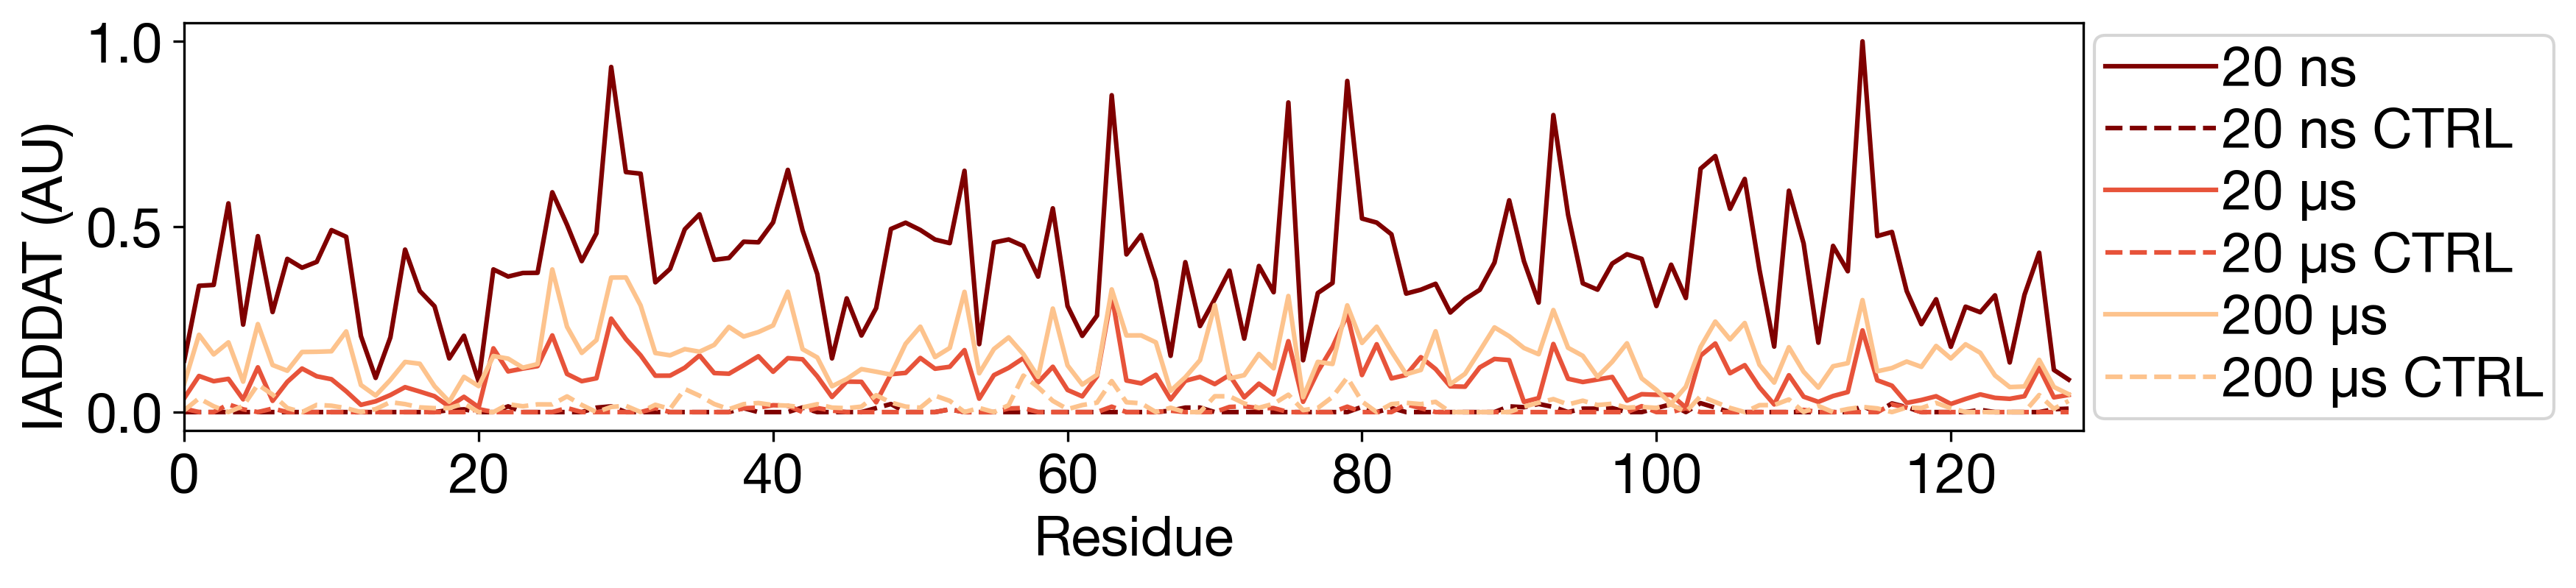

In [188]:
plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT - 0.035 e/A - 2.5 Angstrom Radius")
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))

# hfont = {'fontname':'Helvetica Neue'}
plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[3], label="20 ns")
plt.plot(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[3], label="20 ns CTRL", ls='--')
plt.plot(excited_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[2], label="20 µs")
plt.plot(excited_control_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[2], label="20 µs CTRL", ls='--')
plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[1], label="200 µs")
plt.plot(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color=colors[1], label="200 µs CTRL", ls='--')
plt.xlim(0,129)
plt.xlabel("Residue")
plt.ylabel("IADDAT (AU)", loc='bottom')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

In [116]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT Relative - 0.035 e/A - 2.5 Angstrom Radius")
# plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+2, color="#e8c599", label="200us", lw=1)
# plt.plot(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+2, color="#e8c599", label="200us_control", ls='--')
# plt.plot(excited_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+1, color="#bc6022", label="20us", lw=1)
# plt.plot(excited_control_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+1, color="#bc6022", label="20us_control", ls='--')
# plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#b72818", label="20ns", lw=1)
# plt.plot(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#b72818", label="20ns_control", ls='--')
# plt.axhline(y=0, lw=1, color="#b72818", ls='-')
# plt.axhline(y=0.5, lw=1, color="#b72818", ls=':')
# plt.axhline(y=1, lw=1, color="#bc6022", ls='-')
# plt.axhline(y=1.5, lw=1, color="#bc6022", ls=':')
# plt.axhline(y=2, lw=1, color="#e8c599", ls='-')
# plt.axhline(y=2.5, lw=1, color="#e8c599", ls=':')
# plt.xlim(0,150)
# plt.ylim(0,3)
# plt.xlabel("Residue")
# plt.ylabel("IADDAT (AU)")
# plt.legend(loc='right')
# plt.tight_layout()

In [117]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.title("IADDAT Relative - 0.035 e/A - 2.5 Angstrom Radius")
# plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+2, color="#e8c599", label="200us", lw=1)
# plt.plot(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+2, color="#e8c599", label="200us_control", ls='--')
# plt.plot(excited_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+1, color="#bc6022", label="20us", lw=1)
# plt.plot(excited_control_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max()+1, color="#bc6022", label="20us_control", ls='--')
# plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#b72818", label="20ns", lw=1)
# plt.plot(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang]).max(), color="#b72818", label="20ns_control", ls='--')
# plt.axhline(y=0, lw=1, color="#b72818", ls='-')
# plt.axhline(y=0.5, lw=1, color="#b72818", ls=':')
# plt.axhline(y=1, lw=1, color="#bc6022", ls='-')
# plt.axhline(y=1.5, lw=1, color="#bc6022", ls=':')
# plt.axhline(y=2, lw=1, color="#e8c599", ls='-')
# plt.axhline(y=2.5, lw=1, color="#e8c599", ls=':')
# plt.xlim(0,150)
# plt.ylim(0,3)
# plt.xlabel("Residue")
# plt.ylabel("IADDAT (AU)")
# plt.legend(loc='right')
# plt.tight_layout()

In [189]:
excited_chito_20ns_2point5ang = IADDAT("./F_internal_chito_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_chito_20ns_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

non AA processed


In [190]:
excited_control_chito_20ns_2point5ang = IADDAT("./F_internal_control_chito_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_control_chito_20ns_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

non AA processed


In [191]:
chito_PDB = gemmi.read_structure("./F_internal_control_chito_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb")

In [192]:
elements = [gemmi.Element('C'), gemmi.Element('N'), gemmi.Element('O'), gemmi.Element('S')]
for residue in chito_PDB[0]["A"]:
    atom_coords = []
    for atom in residue:
        if atom.element in elements:
            pos  = {"x": atom.pos.x, "y": atom.pos.y, "z": atom.pos.z}
            atom_coords.append(pos)
        else:
            pass
        atom_coords_df = pd.DataFrame(atom_coords)

In [193]:
if atom_coords_df.empty:
    print("yaya")

yaya


In [194]:
chito_PDB[0]["A"][129][0]

<gemmi.Atom NA at (7.7, 14.3, 31.0)>

In [195]:
excited_chito_200us_2point5ang = IADDAT("./F_internal_chito_200us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_chito_200us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

non AA processed


In [196]:
excited_control_chito_200us_2point5ang = IADDAT("./F_internal_control_chito_200us_540uJ_extrapmap_W0-05_N1_step2.pdb", "./F_internal_control_chito_200us_540uJ_diffmap_W0-05.mtz", volume_to_sigma_04, 2.5, average_out=True)

non AA processed


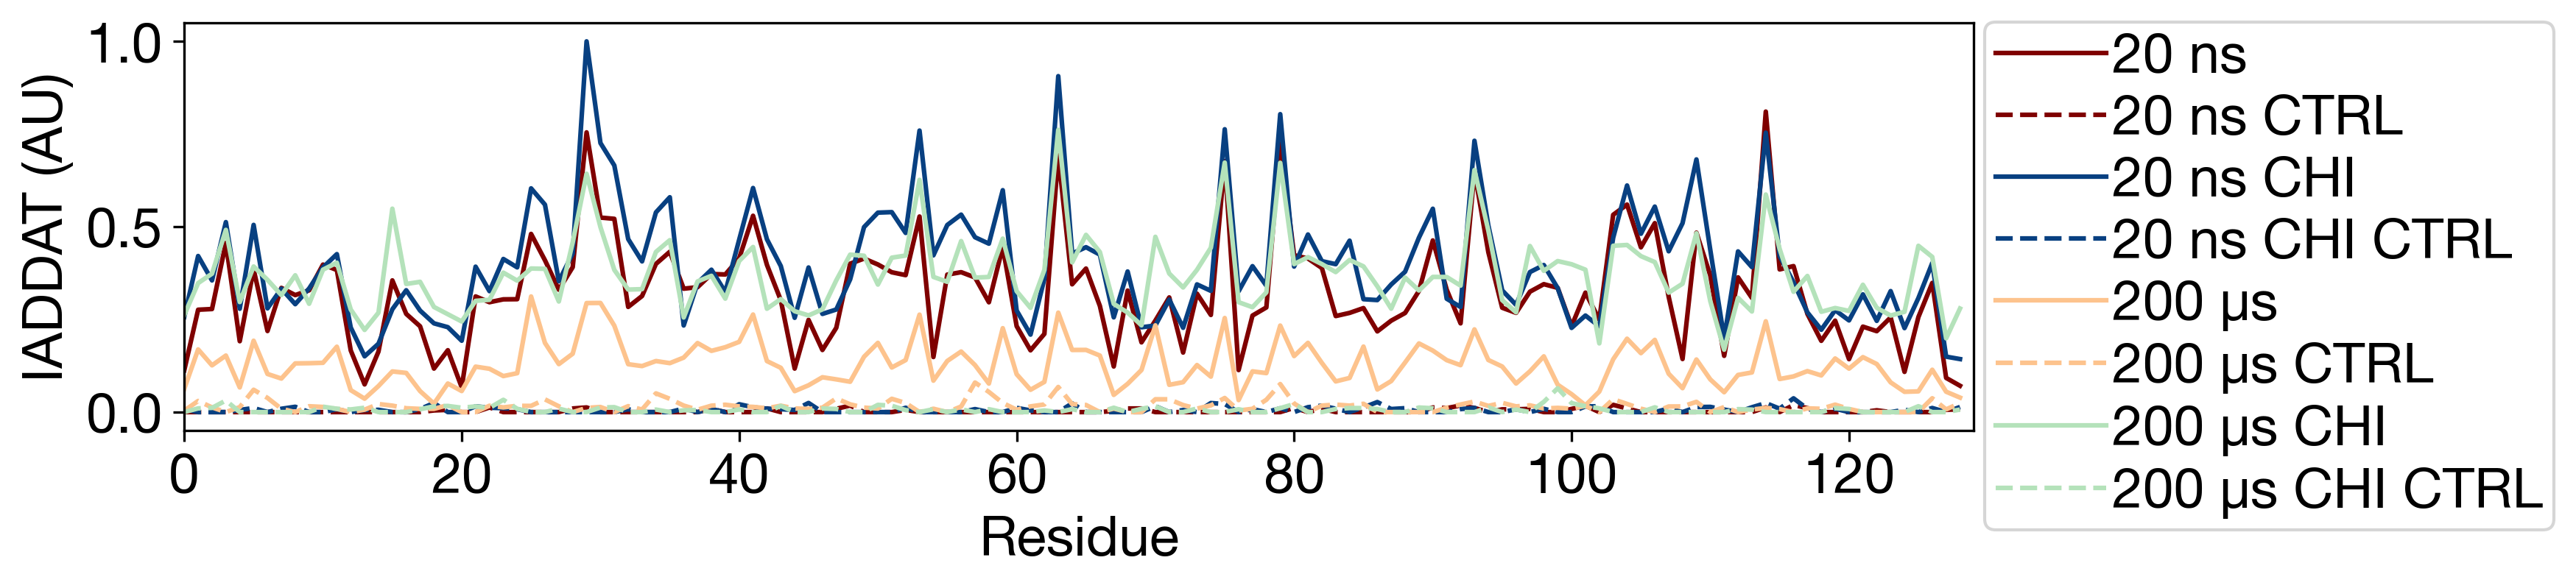

In [197]:
plt.figure(dpi=300, figsize=(12,3))
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))
colors_chi = pl.cm.GnBu(np.linspace(0,1,4))

plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[3], label="20 ns")
plt.plot(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[3], label="20 ns CTRL", ls='--')
plt.plot(excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[3], label="20 ns CHI")
plt.plot(excited_control_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[3], label="20 ns CHI CTRL", ls='--')
plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[1], label="200 µs")
plt.plot(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[1], label="200 µs CTRL", ls='--')
plt.plot(excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[1], label="200 µs CHI")
plt.plot(excited_control_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[1], label="200 µs CHI CTRL", ls='--')


plt.xlim(0,129)
plt.xlabel("Residue")
plt.ylabel("IADDAT (AU)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.38), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

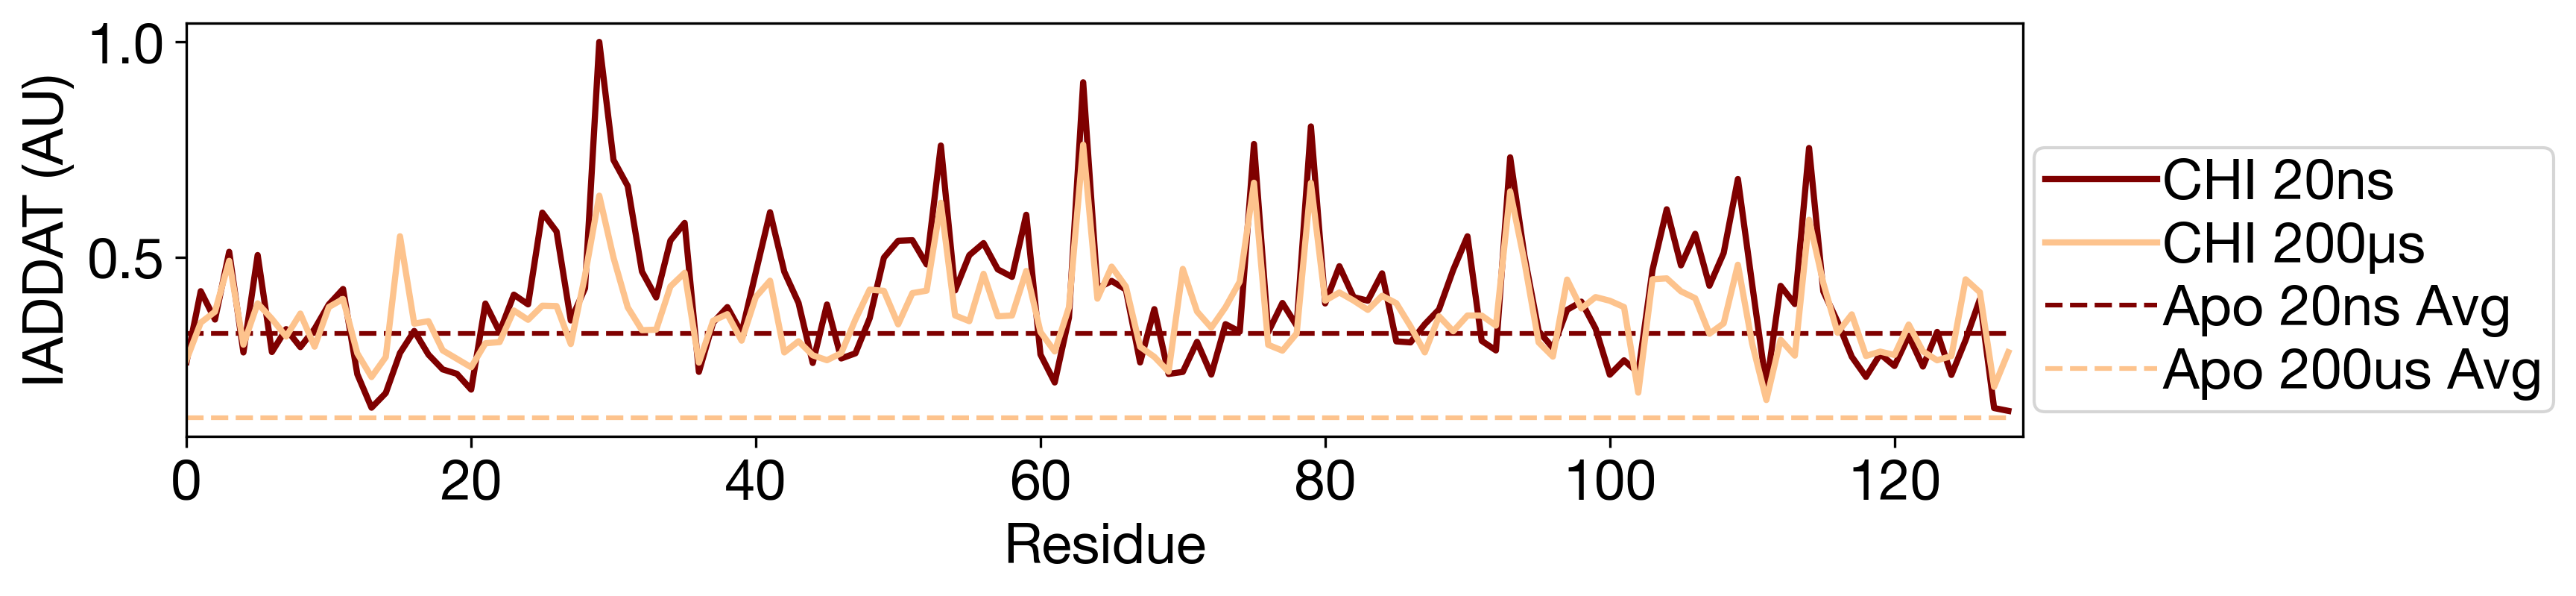

In [198]:
plt.figure(dpi=300, figsize=(12,3))
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))
colors_chi = pl.cm.GnBu(np.linspace(0,1,4))

plt.hlines(np.average(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), 0, 128, color=colors[3], label="Apo 20ns Avg", ls='--')
# plt.plot(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[3], label="Apo 20ns", ls='--')
# plt.plot(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[3], label="20 ns CTRL", ls='--')
plt.plot(excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[3], label="CHI 20ns", lw=2)
# plt.plot(excited_control_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[3], label="20 ns CHI CTRL", ls='--')
plt.hlines(np.average(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), 0, 128, color=colors[1], label="Apo 200us Avg", ls='--')
# plt.plot(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[1], label="Apo 200µs", ls='--')
# plt.plot(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[1], label="200 µs CTRL", ls='--')
plt.plot(excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors[1], label="CHI 200µs", lw=2)
# plt.plot(excited_control_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max(), color=colors_chi[1], label="200 µs CHI CTRL", ls='--')

# ### increased mobility upon ligand-binding based on Wand paper
# plt.vlines(8,0,1, color='green', ls='--', alpha=0.5)
# plt.vlines(98,0,1, color='green', ls='--', alpha=0.5)
# plt.vlines(25,0,1, color='green', ls='--', alpha=0.5)
# plt.vlines(69,0,1, color='green', ls='--', alpha=0.5)

# ### decreased mobility upon ligand-binding based on Wand paper
# plt.vlines(78,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(75,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(105,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(55,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(92,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(83,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(29,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(107,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(11,0,1, color='black', ls='--', alpha=0.5)
# plt.vlines(90,0,1, color='black', ls='--', alpha=0.5)

plt.xlim(0,129)
plt.xlabel("Residue")
plt.ylabel("IADDAT (AU)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.38), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

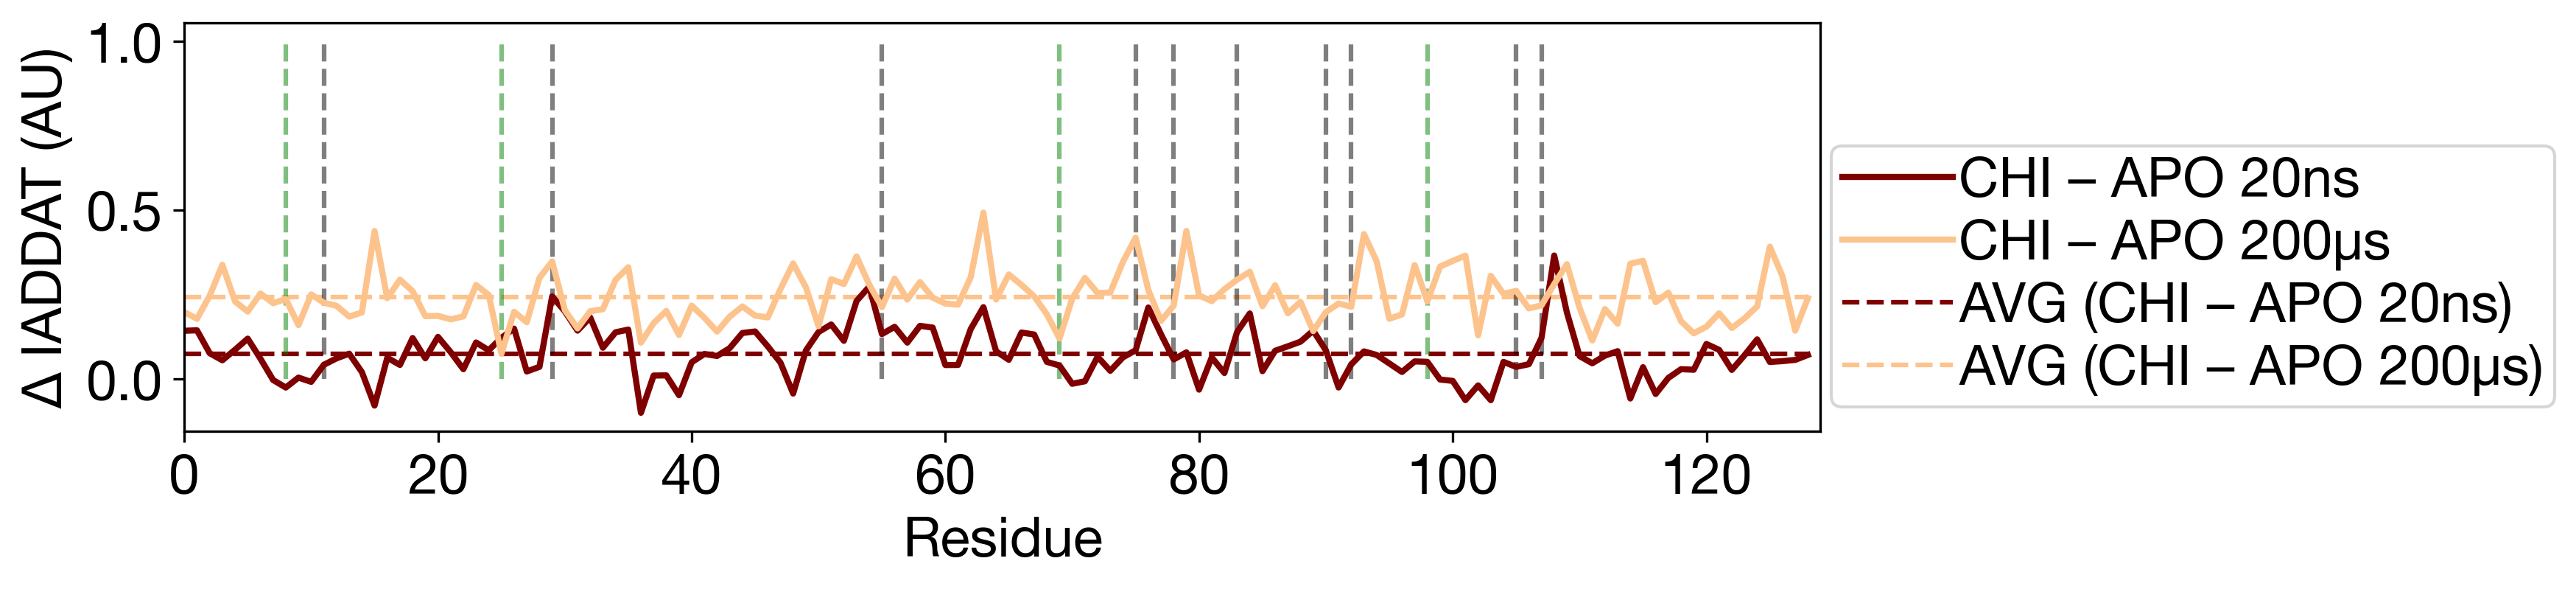

In [199]:
plt.figure(dpi=300, figsize=(12,3))
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))
colors_chi = pl.cm.GnBu(np.linspace(0,1,4))

apo_20ns_IADDAT_scaled = excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
chi_20ns_IADDAT_scaled  = excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()

chi_apo_20ns_delta_IADDAT = chi_20ns_IADDAT_scaled - apo_20ns_IADDAT_scaled

apo_200us_IADDAT_scaled = excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
chi_200us_IADDAT_scaled = excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()

chi_apo_200us_delta_IADDAT = chi_200us_IADDAT_scaled - apo_200us_IADDAT_scaled

plt.plot(chi_apo_20ns_delta_IADDAT, color=colors[3], label="CHI – APO 20ns", lw=2)
plt.plot(chi_apo_200us_delta_IADDAT, color=colors[1], label="CHI – APO 200µs", lw=2)
plt.hlines(np.average(chi_apo_20ns_delta_IADDAT),0,128, color=colors[3], label="AVG (CHI – APO 20ns)", ls='--')
plt.hlines(np.average(chi_apo_200us_delta_IADDAT),0,128, color=colors[1], label="AVG (CHI – APO 200µs)", ls='--')

### increased mobility upon ligand-binding based on Wand paper
plt.vlines(8,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(98,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(25,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(69,0,1, color='green', ls='--', alpha=0.5)

### decreased mobility upon ligand-binding based on Wand paper
plt.vlines(78,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(75,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(105,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(55,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(92,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(83,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(29,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(107,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(11,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(90,0,1, color='black', ls='--', alpha=0.5)

plt.xlim(0,129)
plt.xlabel("Residue")
plt.ylabel("∆ IADDAT (AU)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.38), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

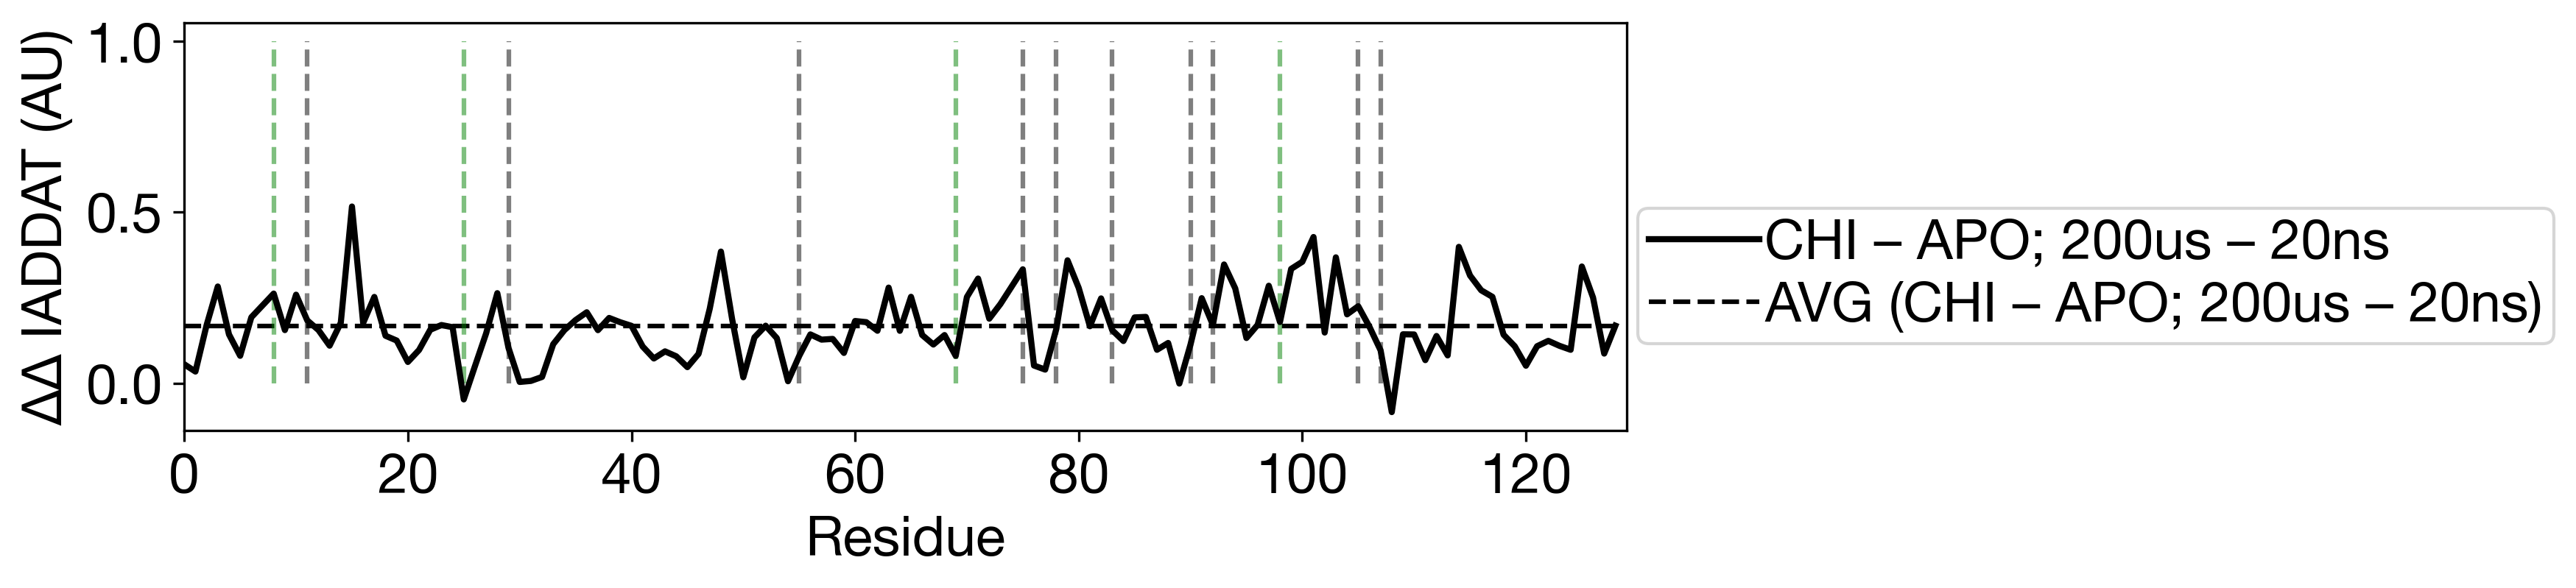

In [200]:
plt.figure(dpi=300, figsize=(12,3))
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))
colors_chi = pl.cm.GnBu(np.linspace(0,1,4))

apo_20ns_IADDAT_scaled = excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
chi_20ns_IADDAT_scaled  = excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()

chi_apo_20ns_delta_IADDAT = chi_20ns_IADDAT_scaled - apo_20ns_IADDAT_scaled

apo_200us_IADDAT_scaled = excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
chi_200us_IADDAT_scaled = excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()

chi_apo_200us_delta_IADDAT = chi_200us_IADDAT_scaled - apo_200us_IADDAT_scaled


chi_apo_200us_20ns_doubledelta_IADDAT = chi_apo_200us_delta_IADDAT - chi_apo_20ns_delta_IADDAT

plt.plot(chi_apo_200us_20ns_doubledelta_IADDAT , color='black', label="CHI – APO; 200us – 20ns", lw=2)
# plt.plot(chi_apo_200us_delta_IADDAT, color=colors[1], label="CHI – APO 200µs", lw=2)
plt.hlines(np.average(chi_apo_200us_20ns_doubledelta_IADDAT),0,128, color='black', label="AVG (CHI – APO; 200us – 20ns)", ls='--')
# plt.hlines(np.average(chi_apo_200us_delta_IADDAT),0,128, color=colors[1], label="AVG (CHI – APO 200µs)", ls='--')

### increased mobility upon ligand-binding based on Wand paper
plt.vlines(8,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(98,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(25,0,1, color='green', ls='--', alpha=0.5)
plt.vlines(69,0,1, color='green', ls='--', alpha=0.5)

### decreased mobility upon ligand-binding based on Wand paper
plt.vlines(78,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(75,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(105,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(55,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(92,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(83,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(29,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(107,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(11,0,1, color='black', ls='--', alpha=0.5)
plt.vlines(90,0,1, color='black', ls='--', alpha=0.5)

plt.xlim(0,129)
plt.xlabel("Residue")
plt.ylabel("∆∆ IADDAT (AU)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.38), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

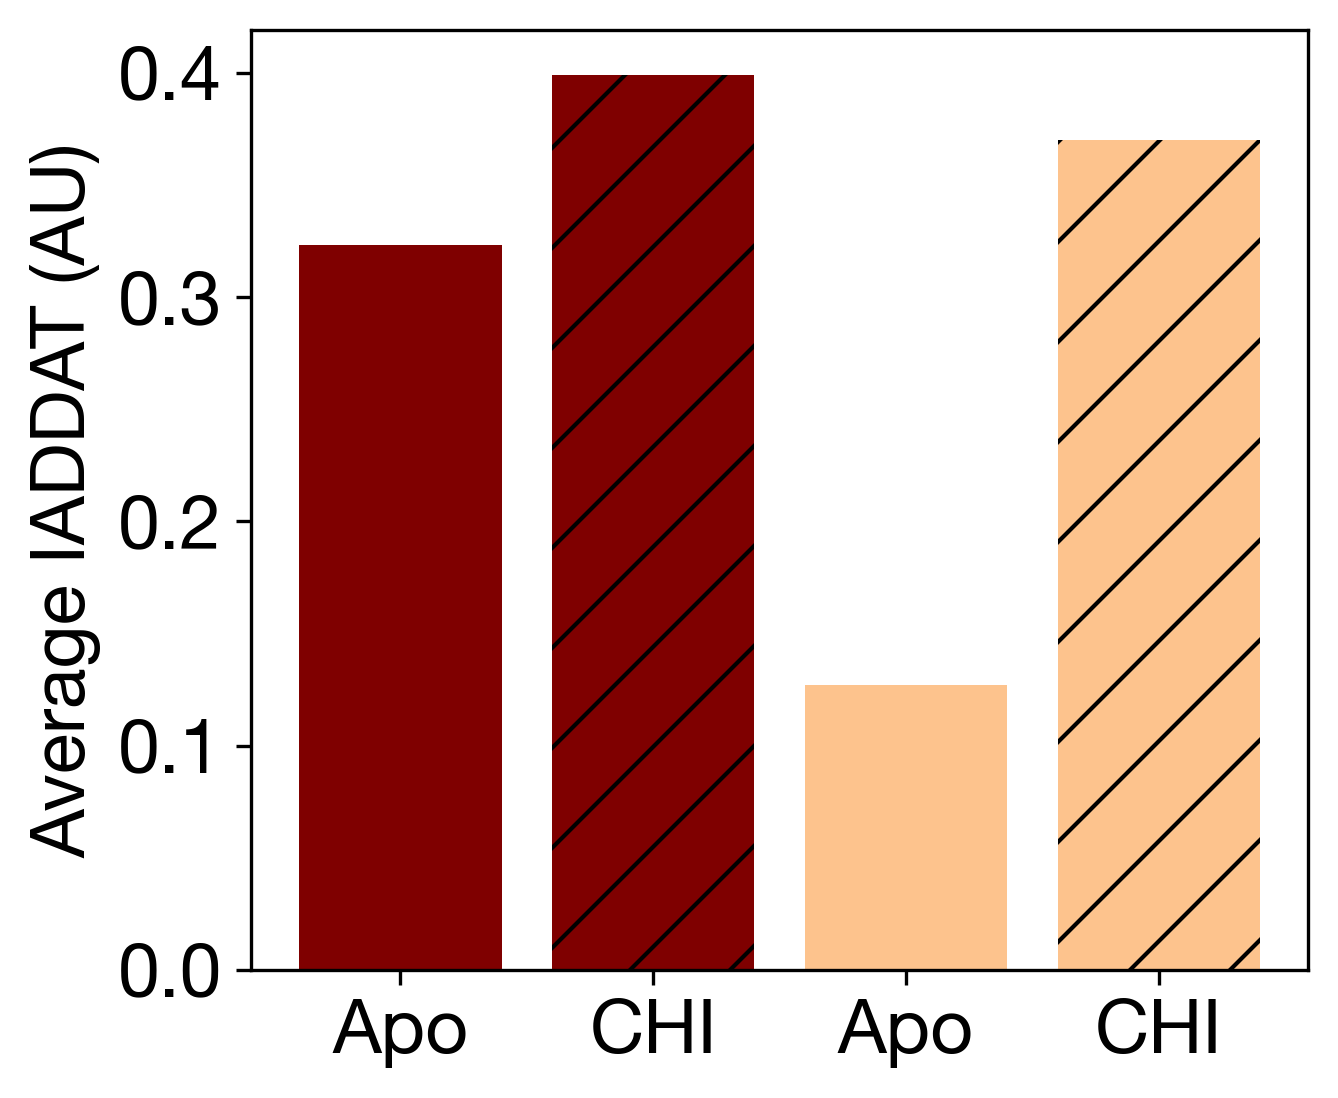

In [201]:
plt.figure(dpi=300, figsize=(4.8,4))
plt.rcParams.update({'font.sans-serif':'Helvetica Neue'})
plt.rcParams.update({'font.size': 18})

colors = pl.cm.OrRd(np.linspace(0,1,4))
colors_chi = pl.cm.GnBu(np.linspace(0,1,4))

plt.bar(0,np.average(excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[3], label="20 ns")
# plt.bar(1,np.average(excited_control_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[3], label="20 ns CTRL", ls='--')
plt.bar(1,np.average(excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[3], label="20 ns CHI", hatch="/")
# plt.bar(3,np.average(excited_control_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors_chi[3], label="20 ns CHI CTRL", ls='--')
plt.bar(2,np.average(excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[1], label="200 µs")
# plt.bar(5,np.average(excited_control_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[1], label="200 µs CTRL", ls='--')
plt.bar(3,np.average(excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors[1], label="200 µs CHI", hatch="/")
# plt.bar(7,np.average(excited_control_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()), color=colors_chi[1], label="200 µs CHI CTRL", ls='--')

plt.xticks([0,1,2,3],["Apo", "CHI", "Apo", "CHI"])
# plt.xlim(0,129)
# plt.xlabel("Residue")
plt.ylabel("Average IADDAT (AU)")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.38), labelspacing=0.2, handletextpad=0.1, borderpad=0.2, borderaxespad=0.2)
plt.tight_layout()

In [202]:
# diff_20ns_20us = np.array(excited_20ns_2point5ang) - np.array(excited_20us_2point5ang)
# diff_20ns_200us = np.array(excited_20ns_2point5ang) - np.array(excited_200us_2point5ang)
# diff_200us_20us = np.array(excited_200us_2point5ang) - np.array(excited_20us_2point5ang)

In [203]:
# plt.figure(dpi=300, figsize=(12,3))
# plt.plot(diff_20ns_20us, label='diff_20ns_20us')
# plt.plot(diff_20ns_200us, label='diff_20ns_200us')
# plt.plot(diff_200us_20us, label='diff_200us_20us')
# plt.legend()

In [204]:
# chito_PDB.write_minimal_pdb("test_chito_write_minimal.pdb")

In [205]:
pwd

'/Users/wolff/ucmerced/tjump_crystallography/map_map_correlations'

In [206]:
chito_PDB[0]["A"][0][0].b_iso = 90

In [207]:
chito_PDB[0]["A"][0][0].b_iso

90.0

In [208]:
### Scaling

scaled_IADDAT_20ns = excited_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
scaled_IADDAT_20us = excited_20us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
scaled_IADDAT_200us = excited_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()

scaled_IADDAT_chito_20ns = excited_chito_20ns_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()
scaled_IADDAT_chito_200us = excited_chito_200us_2point5ang/np.array([excited_20ns_2point5ang, excited_20us_2point5ang, excited_200us_2point5ang, excited_chito_20ns_2point5ang, excited_chito_200us_2point5ang]).max()





In [209]:
IADDAT_PDB_file = gemmi.read_structure("./F_internal_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb")
IADDAT_CHITO_PDB_file = gemmi.read_structure("./F_internal_control_chito_20ns_540uJ_extrapmap_W0-05_N1_step2.pdb")
del IADDAT_CHITO_PDB_file[0]["A"][129] ### delete sodium ion from chain A

In [210]:
def IADDAT_PDB(input_pdb, input_IADDAT, output_filename):
    if len(input_pdb[0]["A"]) == len(input_IADDAT):
        n = 0
        for residue in input_pdb[0]["A"]:
            for atom in residue:
                atom.b_iso = input_IADDAT[n]
            n+=1
        input_pdb.write_minimal_pdb(output_filename)
    else:
        print("failed - IADDAT and residue length do not match")
    return

In [211]:
IADDAT_PDB(IADDAT_PDB_file, scaled_IADDAT_20ns, "20ns_IADDAT-in-bfac-column_avgperresi.pdb")

In [212]:
IADDAT_PDB(IADDAT_PDB_file, scaled_IADDAT_20us, "20us_IADDAT-in-bfac-column_avgperresi.pdb")

In [213]:
IADDAT_PDB(IADDAT_PDB_file, scaled_IADDAT_200us, "200us_IADDAT-in-bfac-column_avgperresi.pdb")

In [214]:
IADDAT_PDB(IADDAT_CHITO_PDB_file, scaled_IADDAT_chito_20ns, "chito_20ns_IADDAT-in-bfac-column_avgperresi.pdb")

In [215]:
IADDAT_PDB(IADDAT_CHITO_PDB_file, scaled_IADDAT_chito_200us, "chito_200us_IADDAT-in-bfac-column_avgperresi.pdb")

In [216]:
pwd

'/Users/wolff/ucmerced/tjump_crystallography/map_map_correlations'

In [217]:
IADDAT_PDB(IADDAT_PDB_file, chi_apo_20ns_delta_IADDAT, "20ns_CHI-Apo_Delta-IADDAT-in-bfac-column_avgperresi.pdb")

In [218]:
IADDAT_PDB(IADDAT_PDB_file, chi_apo_200us_delta_IADDAT, "200us_CHI-Apo_Delta-IADDAT-in-bfac-column_avgperresi.pdb")

In [219]:
chi_delta_IADDAT = chi_200us_IADDAT_scaled - chi_20ns_IADDAT_scaled
apo_delta_IADDAT = apo_200us_IADDAT_scaled - apo_20ns_IADDAT_scaled
IADDAT_PDB(IADDAT_PDB_file, chi_delta_IADDAT, "CHI_200us-20ns_Delta-IADDAT-in-bfac-column_avgperresi.pdb")
IADDAT_PDB(IADDAT_PDB_file, apo_delta_IADDAT, "Apo_200us-20ns_Delta-IADDAT-in-bfac-column_avgperresi.pdb")


chi_delta_IADDAT_ABS = np.abs(chi_delta_IADDAT)
apo_delta_IADDAT_ABS = np.abs(apo_delta_IADDAT)
IADDAT_PDB(IADDAT_CHITO_PDB_file, chi_delta_IADDAT_ABS, "CHI_200us-20ns_Delta-IADDAT-in-bfac-column_avgperresi_ABS.pdb")
IADDAT_PDB(IADDAT_PDB_file, apo_delta_IADDAT_ABS, "Apo_200us-20ns_Delta-IADDAT-in-bfac-column_avgperresi_ABS.pdb")

In [220]:
print(np.min(chi_delta_IADDAT_ABS))
print(np.max(chi_delta_IADDAT_ABS))
print(np.min(apo_delta_IADDAT_ABS))
print(np.max(apo_delta_IADDAT_ABS))

0.00442886551503352
0.3571223536304958
0.01012322784642817
0.5655941818549065


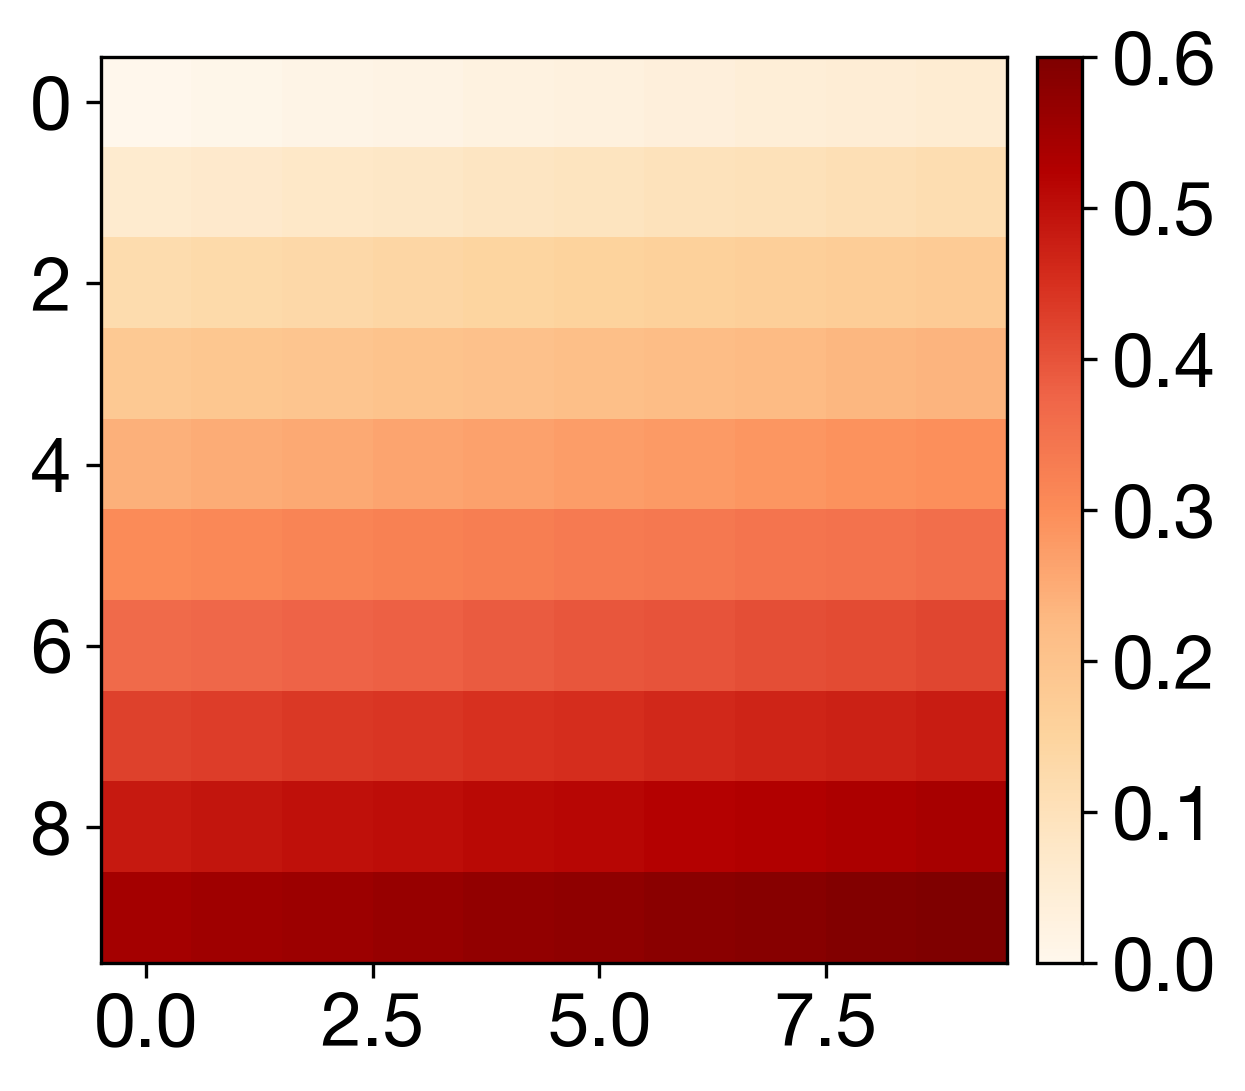

In [221]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(dpi=300)
ax = plt.subplot()
im = ax.imshow(np.linspace(0,0.6,100).reshape((10, 10)), cmap='OrRd')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(im, cax=cax)

plt.show()